In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

2023-06-13 13:55:50.591128: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 13:55:55.374982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 13:55:55.380348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 13:56:06.151364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.12.0


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
import random

In [3]:
import os
os.chdir('/gstore/project/hr_brca_heterogeneity/T47D_trace_Seq_v2/Nathan')
os.listdir()

['bar92196_survexp.csv',
 'bar92196_feature_importance.csv',
 'tran_9545_barcodes.json',
 'cell_cycle_vignette_files',
 'tran_9545_barcodes5.json',
 'tran2_timebar_feature_importance.csv',
 'SHAP',
 'barmodels2',
 'tran_9545_barcodes2.json',
 'barmodels_ptime7',
 'predictedSurvival',
 'barmodels_pathptime9',
 'IBMdata.csv',
 'mse',
 'tran2_validation_feature_importance.csv',
 'pathway_activity_scores.csv',
 'dfs_merged_upload.csv',
 'model_plot.png',
 'tran_9545_barcodes3.json',
 'influenza_transformer',
 'tran_9545_barcodes9.json',
 'tran_9545_barcodes8.json',
 'tran_9545_barcodes4.json',
 'transformer-time-series-prediction',
 'barmodels_pathptime8',
 'barcode_survival.json',
 'jpx',
 'tran_9545_barcodes6.json',
 'barmodels',
 'IBM.csv']

In [4]:
'''Hyperparameters'''

batch_size = 32 # was 32
seq_len = 8 # was 128

#d_k = 256
#d_v = 256
n_heads = 40 # was 60  # Number of attention heads # no difference or imporvement between 5-60
n_head_size= 5 # was 46 # Embedding size for attention # no difference between 5-46
n_ff_dim = 5  # was 55    # Hidden layer size in feed forward network inside transformer # some difference between 5-55


In [8]:
#### full data
import json

# f = open('tran_9545_barcodes2.json') is 25% cells have count of 3 or more (RT-PT)
# f = open('tran_9545_barcodes3.json') is 10% cells have count of 1 or more (RT-PT)
# f = open('tran_9545_barcodes4.json') is PTIME ONLY order with 10% cells have count of 1 or more
# f = open('tran_9545_barcodes5.json') is PTIME ONLY order AND P-SURV with 10% cells have count of 1 or more
f = open('tran_9545_barcodes6.json')
data = json.load(f)

In [9]:
df = pd.DataFrame(data['GFPBC_libB_90850'])
df.iloc[:, 0:len(df.columns)-1]

,Pseudotime,RealTime,Survival,HES4,SDF4,MXRA8,AURKAIP1,MRPL20,SSU72,GNB1,...,HMGB3,CETN2,BCAP31,SSR4,NAA10,TKTL1,RPL10,ATP6AP1,FAM50A,LAGE3
0,28.6784,2,1.3930,1.0657,1.6719,1.0657,1.0657,2.0975,1.0657,1.0657,...,0.0000,1.0657,0.0000,2.9182,0.0000,1.0657,2.4257,2.0975,1.6719,1.0657
1,28.6965,2,1.3914,0.0000,1.0539,2.0802,3.0931,2.4073,2.0802,1.6564,...,2.4073,1.0539,1.0539,2.0802,1.0539,2.8986,2.8986,1.0539,0.0000,1.0539
2,28.6979,3,1.3874,2.4351,0.0000,1.0718,2.7027,1.0718,2.1064,2.1064,...,1.0718,1.0718,0.0000,2.7027,0.0000,1.6799,2.4351,0.0000,0.0000,2.4351
3,28.7070,2,1.3848,0.9582,0.9582,1.5290,1.9369,2.9261,2.5146,0.0000,...,1.5290,1.5290,1.5290,1.9369,2.2545,0.9582,2.9261,1.5290,0.9582,1.5290
4,28.7110,2,1.3808,0.0000,2.2229,0.9389,1.9074,1.9074,1.9074,1.5029,...,0.0000,1.5029,1.5029,2.2229,0.9389,0.9389,2.2229,2.4817,1.5029,0.9389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,66.6957,3,0.9980,0.0000,2.2339,1.5120,2.2339,2.2339,3.0718,2.2339,...,1.5120,0.0000,2.2339,4.1431,1.5120,1.5120,2.7128,0.0000,1.5120,1.5120
2027,66.7072,3,0.9843,3.3632,1.4271,0.8833,2.9554,2.3848,2.6011,2.1304,...,0.0000,0.0000,1.8212,2.7891,2.1304,0.0000,2.7891,2.3848,2.3848,2.3848
2028,66.8890,3,1.0137,2.6044,2.1335,0.8851,3.1081,2.1335,2.6044,0.0000,...,0.8851,1.8241,2.3881,3.3668,1.4297,0.0000,3.2432,2.1335,1.4297,1.4297
2029,66.9483,4,1.0123,1.8021,1.8021,0.0000,3.4527,2.3633,2.7663,1.4104,...,0.8711,2.5788,0.8711,2.9322,2.1098,0.0000,1.4104,0.8711,2.1098,0.8711


In [10]:
exp_days = {'Day 0': 1, 'Day 1': 2, 'Day 4': 3, 'Day 8': 4, 'Day 26': 5}

In [11]:
barcodes = [i for i in data.keys()]
new_barcodes = []
for i in barcodes:
    df = pd.DataFrame(data[i])
    print(i, df.shape[0])
    if df.shape[0] > 500: # 50 or 60
        new_barcodes.append(i)
print(len(new_barcodes))

bar_dict = {new_barcodes[i]:i for i in range(len(new_barcodes))}

GFPBC_libB_10737 264
GFPBC_libB_83026 577
GFPBC_libB_64846 75
GFPBC_libB_40758 457
GFPBC_libB_76585 36
GFPBC_libB_20182 1528
GFPBC_libB_90850 2031
GFPBC_libB_37798 1670
GFPBC_libB_92196 2733
GFPBC_libB_10678 1040
GFPBC_libB_94397 468
GFPBC_libB_78143 150
GFPBC_libB_81397 233
GFPBC_libB_72163 101
GFPBC_libB_23768 126
GFPBC_libB_61810 45
GFPBC_libB_66263 222
GFPBC_libB_9608 104
GFPBC_libB_93286 43
GFPBC_libB_31581 490
GFPBC_libB_86192 48
GFPBC_libB_51456 157
GFPBC_libB_51538 41
GFPBC_libB_92957 52
GFPBC_libB_53703 57
GFPBC_libB_22922 29
GFPBC_libB_47768 56
GFPBC_libB_15870 191
GFPBC_libB_37507 138
GFPBC_libB_66513 37
GFPBC_libB_68568 93
GFPBC_libB_97905 70
GFPBC_libB_31782 66
GFPBC_libB_92722 76
GFPBC_libB_64979 30
GFPBC_libB_86618 28
GFPBC_libB_40179 37
GFPBC_libB_62053 50
GFPBC_libB_57574 32
GFPBC_libB_20511 111
GFPBC_libB_92859 40
GFPBC_libB_47508 38
6


In [12]:
'''Create training and test data'''

def transformer_train_test_split_dayiter(bar, frac_val, day, extra_var_bool):
    
    bardf = pd.DataFrame(data[bar])
    bardf = bardf[bardf['RealTime'] <= exp_days[d]]
    num_cell_day = len(bardf[bardf['RealTime'] == exp_days[d]])
    
    bardf = bardf.iloc[:,:len(bardf.columns)-1]
    bardf['RealTime'] = bardf['RealTime'].astype('category')
    bardf['Barcode'] = [bar_dict[bar] for _ in range(bardf.shape[0])]
    bardf['Barcode'] = bardf['Barcode'].astype('category')
    
    # normalize after train/test split
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    bardf2 = pd.DataFrame(scaler.fit_transform(bardf.iloc[:,2:len(bardf.columns)-1])) # survival and expression
    bardf2.columns = bardf.columns[2:len(bardf.columns)-1]
    
    if extra_var_bool[0]:
        bardf2['RealTime'] = bardf['RealTime'].astype('category')
        num_cell_day = len(bardf2[bardf2['RealTime'] == exp_days[d]])
    if extra_var_bool[1]:
        bardf2['Barcode'] = bardf['Barcode'].astype('category')
    if extra_var_bool[2]:
        bardf2['Pseudotime'] = bardf['Pseudotime']
    #bardf2 = bardf2.dropna()
    COLS = bardf2.columns.tolist()[1:]
    #print(COLS)
    
    bardf2 = bardf2.dropna()
    bardf2.index = [i for i in range(bardf2.shape[0])]
    bardf_train = bardf2[:-(round(num_cell_day*frac_val))]
    bardf_val = bardf2[len(bardf2) - (round(num_cell_day*frac_val)):]
    
    train_y = bardf_train['Survival']
    train_data = bardf_train.iloc[:,1:]
    val_y = bardf_val['Survival'].tolist()
    val_data = bardf_val.iloc[:,1:]
    #print(train_data.shape, train_y.shape)
    #print(val_data.shape, len(val_y))
    
    # Training data
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
      X_train.append(train_data[i-seq_len:i]) 
      y_train.append(train_y[i]) #Value of 0th column (Survival) of df-row seq_len+1
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Validation data
    X_val, y_val = [], []
    for i in range(seq_len, len(val_data)):
      X_val.append(val_data[i-seq_len:i]) 
      y_val.append(val_y[i]) #Value of 0th column (Survival) of df-row seq_len+1
    X_val, y_val = np.array(X_val), np.array(y_val)
    
    print('Transformer Training/Val set shapes (varies depending on barcode) ', X_train.shape, X_val.shape)
    return X_train, y_train, X_val, y_val, COLS

In [13]:
'''Create training and test data'''

def regr_train_test_split_dayiter(bar, frac_val, day, extra_var_bool):
    
    bardf = pd.DataFrame(data[bar])
    bardf = bardf[bardf['RealTime'] <= exp_days[d]]
    num_cell_day = len(bardf[bardf['RealTime'] == exp_days[d]])
    
    bardf = bardf.iloc[:,:len(bardf.columns)-1]
    bardf['RealTime'] = bardf['RealTime'].astype('category')
    bardf['Barcode'] = [bar_dict[bar] for _ in range(bardf.shape[0])]
    bardf['Barcode'] = bardf['Barcode'].astype('category')
    
    # normalize after train/test split
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    bardf2 = pd.DataFrame(scaler.fit_transform(bardf.iloc[:,2:len(bardf.columns)-1])) # survival and expression
    bardf2.columns = bardf.columns[2:len(bardf.columns)-1]
    
    if extra_var_bool[0]:
        bardf2['RealTime'] = bardf['RealTime'].astype('category')
        num_cell_day = len(bardf2[bardf2['RealTime'] == exp_days[d]])
    if extra_var_bool[1]:
        bardf2['Barcode'] = bardf['Barcode'].astype('category')
    if extra_var_bool[2]:
        bardf2['Pseudotime'] = bardf['Pseudotime']
        
    bardf2 = bardf2.dropna()
    bardf2.index = [i for i in range(bardf2.shape[0])]
    bardf_train = bardf2[:-(round(num_cell_day*frac_val))]
    bardf_val = bardf2[len(bardf2) - (round(num_cell_day*frac_val)):]
    
    train_y = bardf_train['Survival']
    train_data = bardf_train.iloc[:,1:]
    val_y = bardf_val['Survival'].tolist()
    val_data = bardf_val.iloc[:,1:]
    
    # Training data
    X_train, y_train = np.array(train_data), np.array(train_y)
    
    # Validation data
    X_val, y_val = np.array(val_data), np.array(val_y)
    
    print('Regr Training/Val set shapes (varies depending on barcode) ', X_train.shape, X_val.shape)
    return X_train, y_train, X_val, y_val

In [14]:
########### testing function #################
# make the training and validation data
'''
days = ['Day 0', 'Day 1', 'Day 4', 'Day 8', 'Day 26']
b = 'GFPBC_libB_92196'
frac_val = 0.20
extra_var_bool = [True, True, True] # 0-realtime, 1-barcode, 2-pseudotime
for d in days:
    X_train, y_train, X_val, y_val, cols = transformer_train_test_split_dayiter(b, frac_val, d, extra_var_bool)
    X_train, y_train, X_val, y_val = regr_train_test_split_dayiter(b, frac_val, d, extra_var_bool)
'''

"\ndays = ['Day 0', 'Day 1', 'Day 4', 'Day 8', 'Day 26']\nb = 'GFPBC_libB_92196'\nfrac_val = 0.20\nextra_var_bool = [True, True, True] # 0-realtime, 1-barcode, 2-pseudotime\nfor d in days:\n    X_train, y_train, X_val, y_val, cols = transformer_train_test_split_dayiter(b, frac_val, d, extra_var_bool)\n    X_train, y_train, X_val, y_val = regr_train_test_split_dayiter(b, frac_val, d, extra_var_bool)\n"

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    
    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        # "EMBEDDING LAYER"
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)

        # "ATTENTION LAYER"
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
        x = layers.Dropout(dropout)(x)
        res = x + inputs
    
    for _ in range(num_transformer_blocks):
        # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [16]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0, 
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # This is what stacks our transformer blocks
    x = transformer_encoder(x, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [17]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [18]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [19]:
from keras.utils.vis_utils import plot_model
import pydot
import graphviz

#tf.keras.utils.plot_model(model, to_file ='model_plot.png', show_shapes = True, show_layer_names = True)

In [20]:
def SHAPvals(X_val, y_val, bar, COLS, dir_path):
    
    #COLS = bardf.columns.tolist()[1:] # may need fixing
    #print(len(COLS), X_val.shape)
    #print(COLS)

    results = []
    print(' Computing feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = model.predict(X_val, verbose=0).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y_val ))
    results.append({'feature':'BASELINE','mae':baseline_mae})           

    for k in range(len(COLS)):

        if k in [200, 400, 600, 800, 1000]:
            print('SHAP', k)
        # SHUFFLE FEATURE K
        save_col = X_val[:,:,k].copy()
        np.random.shuffle(X_val[:,:,k])

        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X_val, verbose=0).squeeze() 
        mae = np.mean(np.abs( oof_preds-y_val ))
        results.append({'feature':COLS[k],'mae':mae})
        X_val[:,:,k] = save_col

    # DISPLAY FEATURE IMPORTANCE
    print()
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    plt.figure(figsize=(10,20))
    plt.barh(np.arange(len(COLS)+1),df.mae)
    plt.yticks(np.arange(len(COLS)+1),df.feature.values)
    plt.title('Feature Importance',size=16)
    plt.ylim((-1,len(COLS)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
             label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
    plt.xlabel(f'OOF MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    # SAVE FEATURE IMPORTANCE
    df = df.sort_values('mae',ascending=False)
    df.to_csv(dir_path+bar+'_feature_importance.csv',index=False)

In [21]:
def plot_transformer_predictions_losses(X_train, y_train, X_val, y_val, bar, day, dir_path):
    
    #Calculate predication for training, validation and test data
    print(X_train.shape, X_val.shape)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    #Print evaluation metrics for all datasets
    #train_eval = model.evaluate(X_train, y_train, verbose=0)
    #val_eval = model.evaluate(X_val, y_val, verbose=0)
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    print(' ')
    print('Transformer Evaluation metrics')
    #print('Transformer Training Data - Loss: {:.4f}, MSE: {:.4f}'.format(train_eval[0], train_eval[1])) ### these lines should be MSE???
    #print('Transformer Validation Data - Loss: {:.4f}, MSE: {:.4f}'.format(val_eval[0], val_eval[1]))
    print('Transformer Training MSE - MSE: {:.4f}'.format(train_mse)) ### these lines should be MSE???
    print('Transformer Validation MSE - MSE: {:.4f}'.format(val_mse))
    

    plt.plot(y_train, label='Survival')
    plt.plot(np.arange(train_pred.shape[0]), train_pred, linewidth=3, label='Predicted Survival')
    plt.title(day+" Transformer Training Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_training.png', bbox_inches='tight')
    plt.show()

    #Plot validation data results
    plt.plot(y_val, label='Survival')
    plt.plot(np.arange(val_pred.shape[0]), val_pred, linewidth=3, label='Predicted Survival')
    plt.title(day+" Transformer Validation Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_validation.png', bbox_inches='tight')
    plt.show()
    
    return train_mse, val_mse

In [22]:
def plot_regr_predictions_losses(X_train, y_train, X_val, y_val, bar, day, dir_path):
    
    #Calculate predication for training, validation and test data
    train_pred = regr.predict(X)
    val_pred = regr.predict(X_test)

    #Print evaluation metrics for all datasets
    train_eval = mean_squared_error(y, train_pred)
    val_eval = mean_squared_error(y_test, val_pred)
    print(' ')
    print('Evaluation metrics Regr')
    print('Regr Training Data - MSE: {:.4f}'.format(train_eval)) ### these lines should be MSE???
    print('Regr Validation Data - MSE: {:.4f}'.format(val_eval))
    
    plt.plot(y, label='Survival')
    plt.plot(np.arange(train_pred.shape[0]), train_pred, linewidth=3, label='Predicted Survival')
    plt.title(day+" Regr Training Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_training.png', bbox_inches='tight')
    plt.show()

    #Plot validation data results
    plt.plot(y_test, label='Survival')
    plt.plot(np.arange(val_pred.shape[0]), val_pred, linewidth=3, label='Predicted Survival')
    plt.title(day+" Regr Validation Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_validation.png', bbox_inches='tight')
    plt.show()
    
    return train_eval, val_eval

In [23]:
# set seeds produces more similar results, but not exact
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)




GFPBC_libB_92196
Transformer Training/Val set shapes (varies depending on barcode)  (339, 8, 1969) (79, 8, 1969)
Epoch 1/5
11/11 [==============================] - 6s 119ms/step - loss: 0.3390 - mean_squared_error: 0.3390 - val_loss: 0.0573 - val_mean_squared_error: 0.0573
Epoch 2/5
11/11 [==============================] - 1s 60ms/step - loss: 0.0712 - mean_squared_error: 0.0712 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 3/5
11/11 [==============================] - 1s 54ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 4/5
11/11 [==============================] - 1s 48ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 5/5
11/11 [==============================] - 0s 45ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
(339, 8, 1969) (79, 8, 1969)
3/3 [==============================] - 0s 13ms/step
 


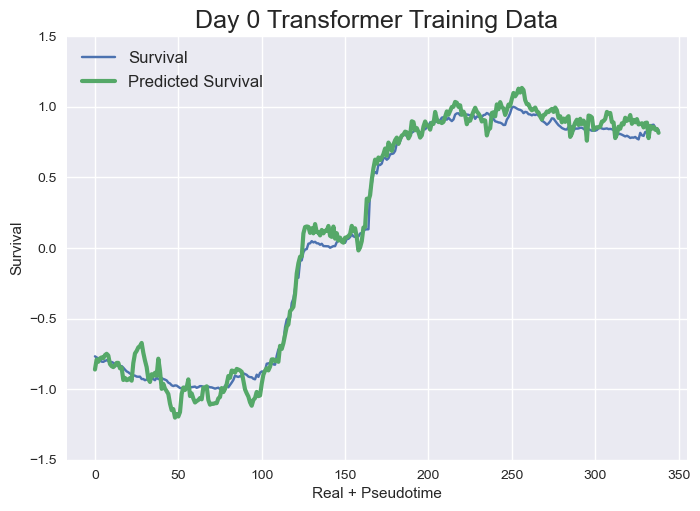

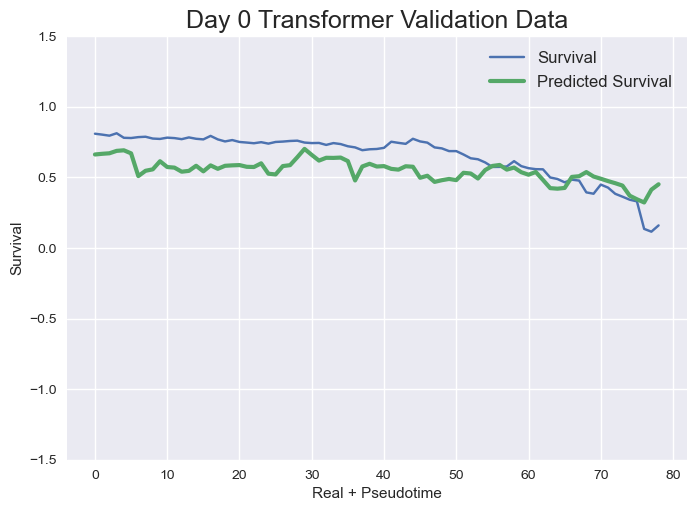

Regr Training/Val set shapes (varies depending on barcode)  (347, 1969) (87, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 0.6290


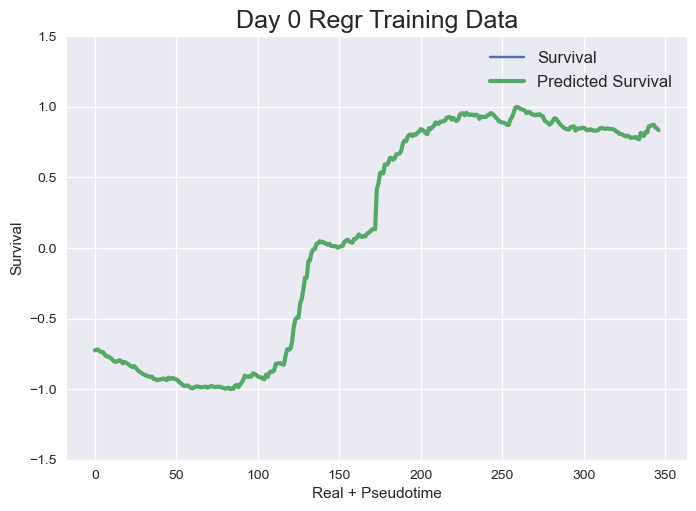

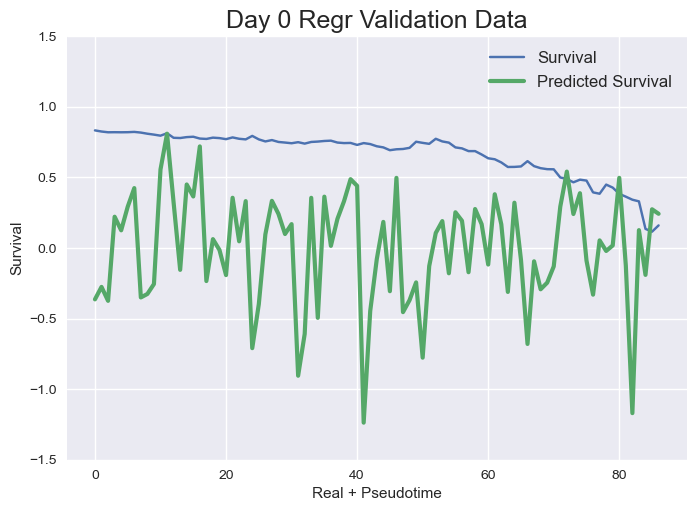

Transformer Training/Val set shapes (varies depending on barcode)  (756, 8, 1969) (74, 8, 1969)
Epoch 1/5
24/24 [==============================] - 4s 70ms/step - loss: 0.2282 - mean_squared_error: 0.2282 - val_loss: 0.0683 - val_mean_squared_error: 0.0683
Epoch 2/5
24/24 [==============================] - 1s 45ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0618 - val_mean_squared_error: 0.0618
Epoch 3/5
24/24 [==============================] - 1s 39ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 4/5
24/24 [==============================] - 1s 36ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 5/5
24/24 [==============================] - 1s 33ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0585 - val_mean_squared_error: 0.0585
(756, 8, 1969) (74, 8, 1969)
3/3 [==============================] - 0s 18ms/step
 
Transformer Evaluatio

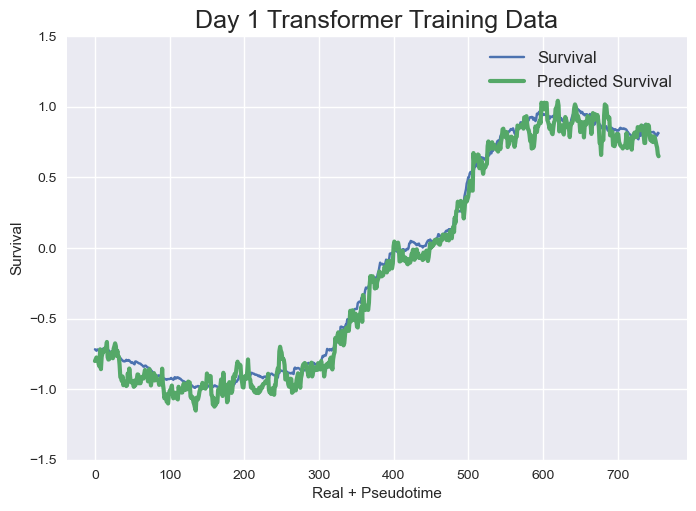

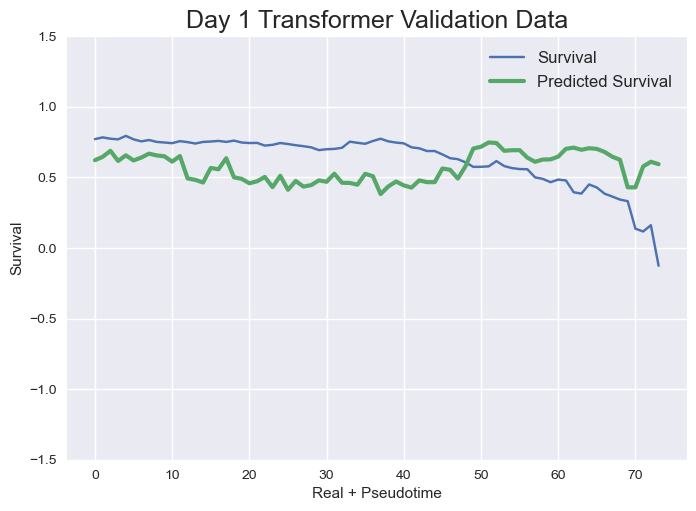

Regr Training/Val set shapes (varies depending on barcode)  (764, 1969) (82, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 0.6461


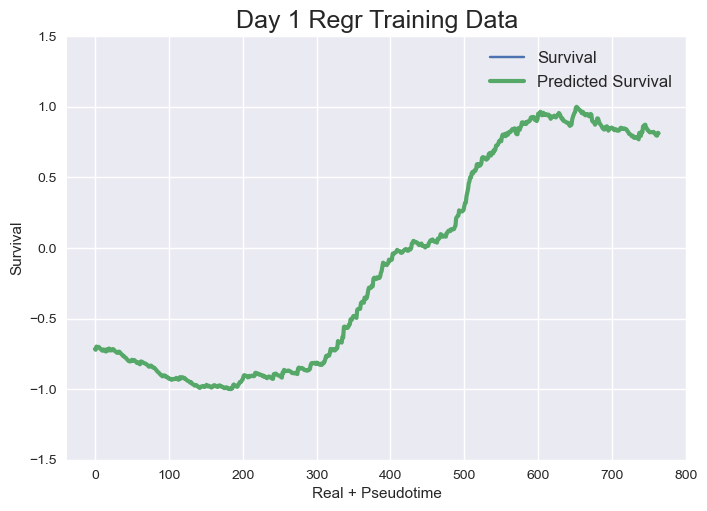

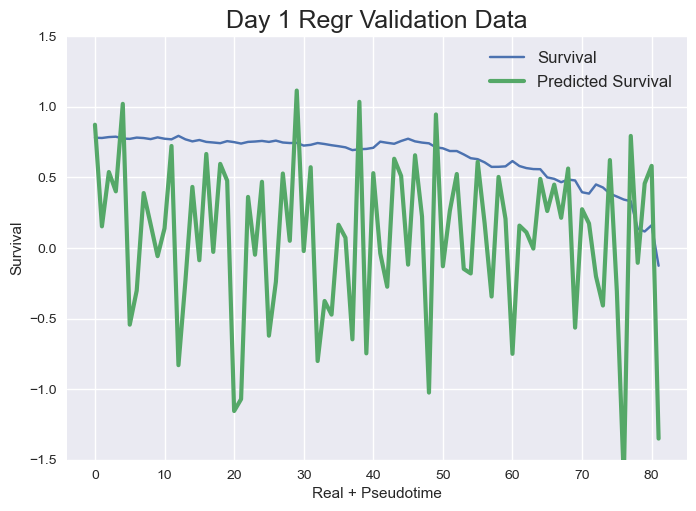

Transformer Training/Val set shapes (varies depending on barcode)  (1315, 8, 1969) (111, 8, 1969)
Epoch 1/5
42/42 [==============================] - 5s 52ms/step - loss: 0.2283 - mean_squared_error: 0.2283 - val_loss: 0.0914 - val_mean_squared_error: 0.0914
Epoch 2/5
42/42 [==============================] - 2s 41ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - val_loss: 0.1314 - val_mean_squared_error: 0.1314
Epoch 3/5
42/42 [==============================] - 1s 32ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 4/5
42/42 [==============================] - 1s 30ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.1309 - val_mean_squared_error: 0.1309
Epoch 5/5
42/42 [==============================] - 1s 29ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
(1315, 8, 1969) (111, 8, 1969)
4/4 [==============================] - 0s 13ms/step
 
Transformer Evalu

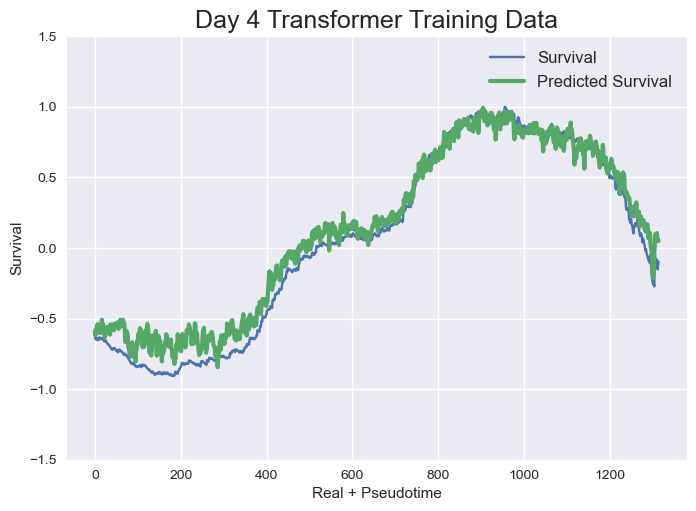

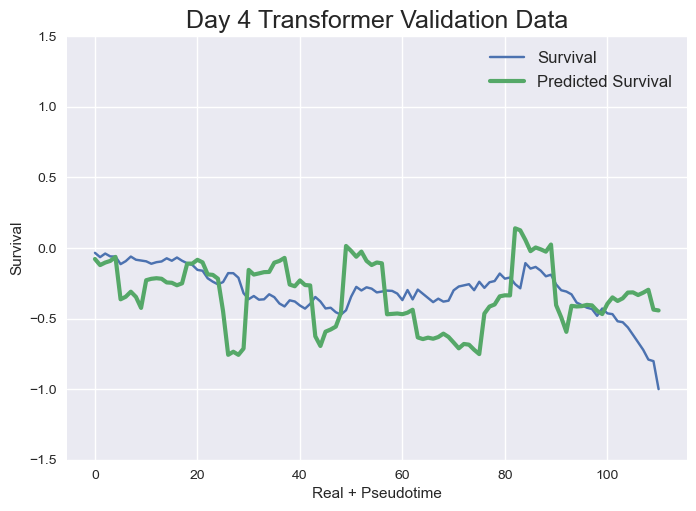

Regr Training/Val set shapes (varies depending on barcode)  (1323, 1969) (119, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 0.8544


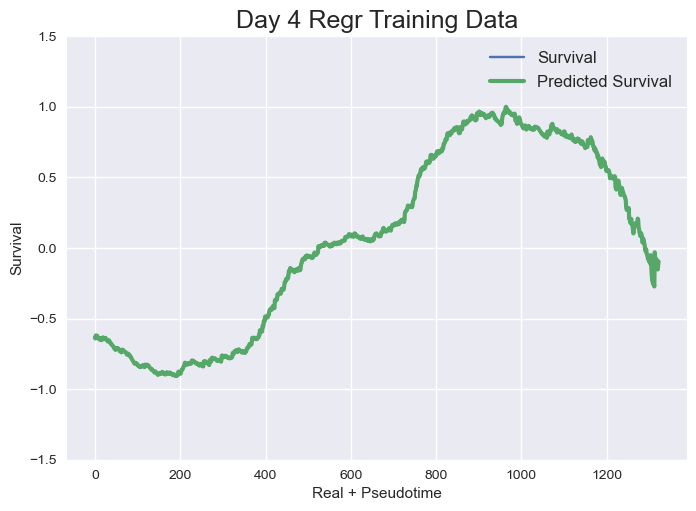

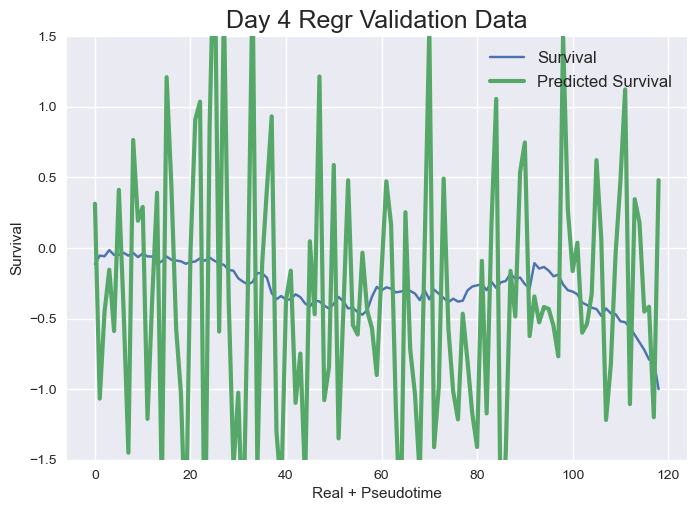

Transformer Training/Val set shapes (varies depending on barcode)  (2200, 8, 1969) (183, 8, 1969)
Epoch 1/5
69/69 [==============================] - 7s 44ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.0519 - val_mean_squared_error: 0.0519
Epoch 2/5
69/69 [==============================] - 3s 38ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0558 - val_mean_squared_error: 0.0558
Epoch 3/5
69/69 [==============================] - 2s 31ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 4/5
69/69 [==============================] - 2s 29ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 5/5
69/69 [==============================] - 2s 29ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0662 - val_mean_squared_error: 0.0662
(2200, 8, 1969) (183, 8, 1969)
6/6 [==============================] - 0s 16ms/step
 
Transformer Evalu

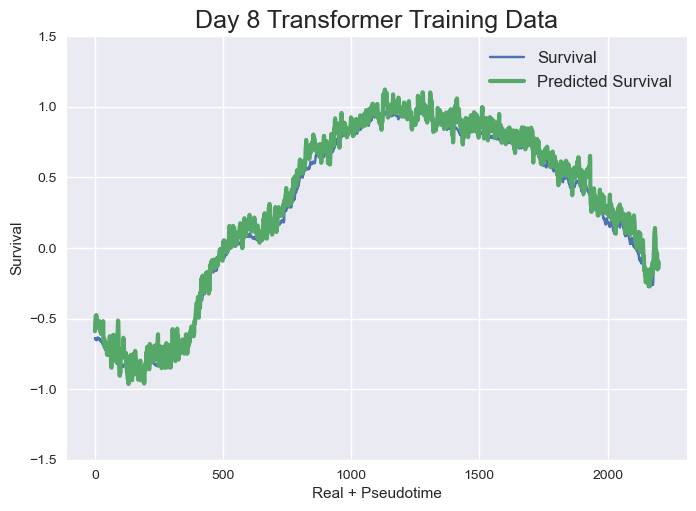

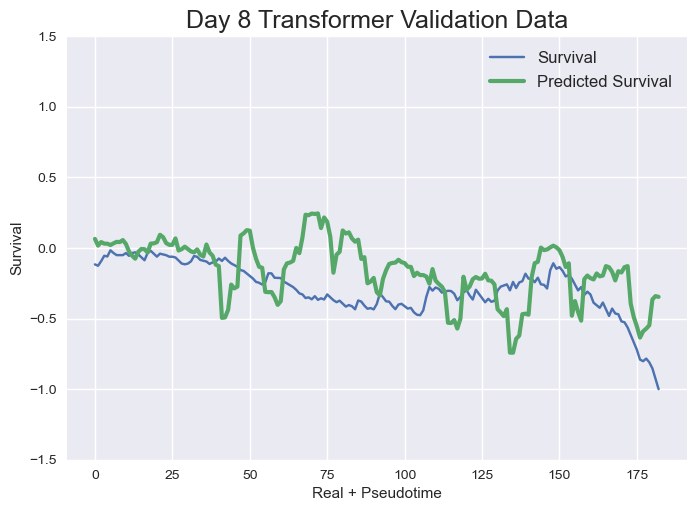

Regr Training/Val set shapes (varies depending on barcode)  (2208, 1969) (191, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0171
Regr Validation Data - MSE: 1.8555


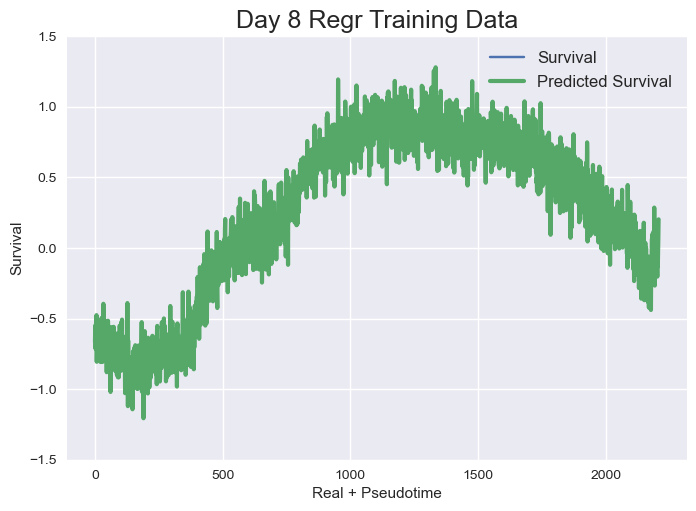

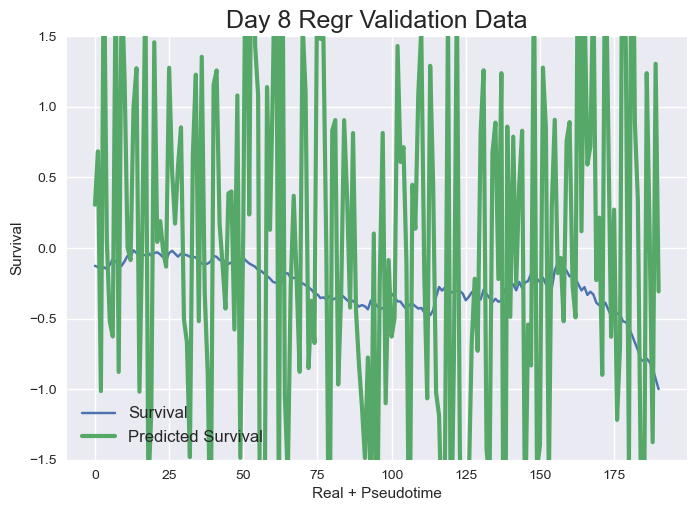

Transformer Training/Val set shapes (varies depending on barcode)  (2658, 8, 1969) (59, 8, 1969)
Epoch 1/5
84/84 [==============================] - 5s 39ms/step - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.1559 - val_mean_squared_error: 0.1559
Epoch 2/5
84/84 [==============================] - 3s 35ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0861 - val_mean_squared_error: 0.0861
Epoch 3/5
84/84 [==============================] - 2s 29ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 4/5
84/84 [==============================] - 2s 28ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 5/5
84/84 [==============================] - 2s 28ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0843 - val_mean_squared_error: 0.0843
(2658, 8, 1969) (59, 8, 1969)
2/2 [==============================] - 0s 16ms/step
 
Transformer Evaluat

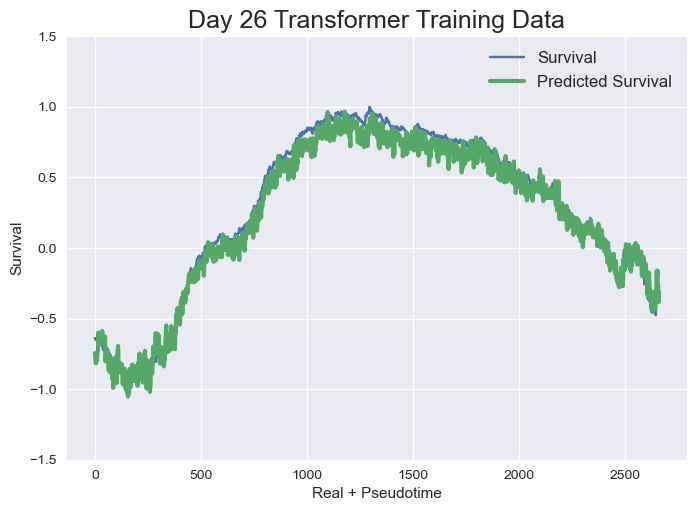

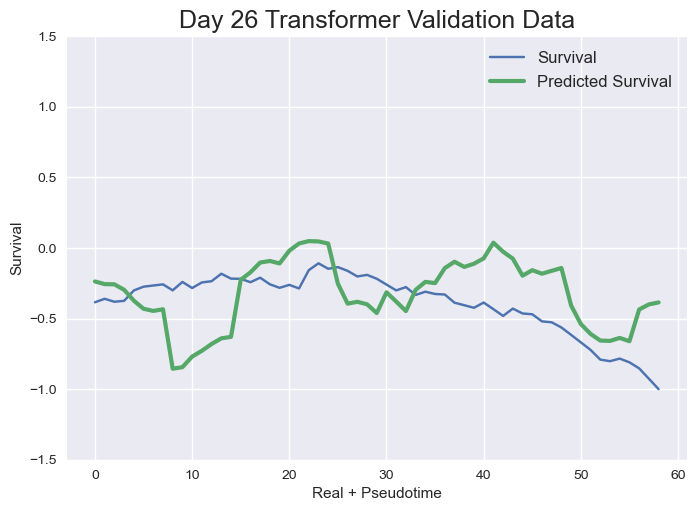

Regr Training/Val set shapes (varies depending on barcode)  (2666, 1969) (67, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0436
Regr Validation Data - MSE: 0.5985


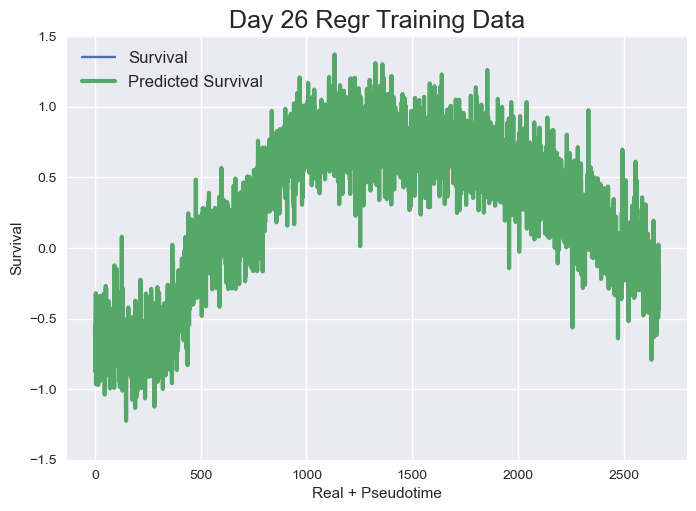

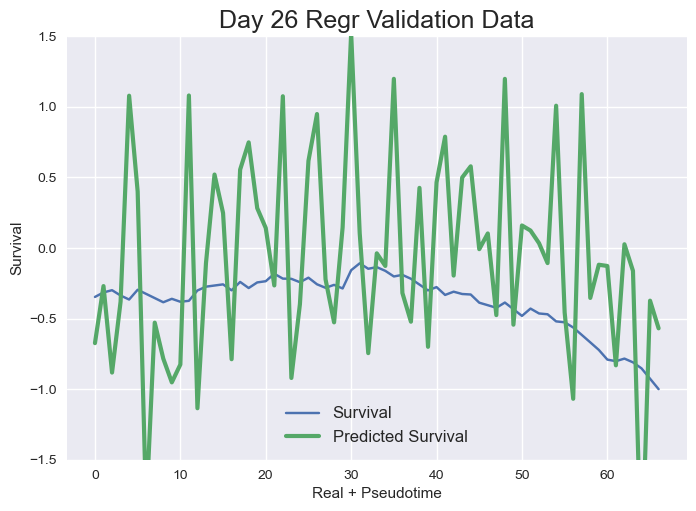

{'Day 0': [0.006634771367156116, 0.024963006012977018, 2.412171864045748e-29, 0.6289791666607851], 'Day 1': [0.006248040986453201, 0.05851086253448948, 9.100244855453534e-30, 0.6460926894036103], 'Day 4': [0.0124497866195205, 0.06146441748998759, 1.1482141031527914e-29, 0.8543599441301599], 'Day 8': [0.0058736837195811275, 0.0661671686639911, 0.017134677424355243, 1.8554503512397105], 'Day 26': [0.006594631118308579, 0.08427307765215632, 0.043587453916379436, 0.5985001027812732]}
{'GFPBC_libB_92196': {'Day 0': [0.006634771367156116, 0.024963006012977018, 2.412171864045748e-29, 0.6289791666607851], 'Day 1': [0.006248040986453201, 0.05851086253448948, 9.100244855453534e-30, 0.6460926894036103], 'Day 4': [0.0124497866195205, 0.06146441748998759, 1.1482141031527914e-29, 0.8543599441301599], 'Day 8': [0.0058736837195811275, 0.0661671686639911, 0.017134677424355243, 1.8554503512397105], 'Day 26': [0.006594631118308579, 0.08427307765215632, 0.043587453916379436, 0.5985001027812732]}}


In [24]:
# use partial_fit to train multiple times, could be different barcodes in our case
frac_val = 0.20
test_bars = ['GFPBC_libB_92196'] #, 'GFPBC_libB_90850', 'GFPBC_libB_20182'] #'GFPBC_libB_78143', 'GFPBC_libB_78143', 'GFPBC_libB_78143']
days = ['Day 0', 'Day 1', 'Day 4', 'Day 8', 'Day 26']
extra_var_bool = [False, False, False] # 0-realtime, 1-barcode, 2-pseudotime

mse_dict = {} # structure is {barcode: {day_0: [trans_train, trans_val, regr_train, regr_val], day_n...}, barcode_n: ...}

for bar in test_bars: # test_bars
    
    print('\n\n')
    print(bar)
    mse_dict[bar] = {}
    
    # make the training and validation data
    for d in days:
        X_train, y_train, X_val, y_val, COLS = transformer_train_test_split_dayiter(bar, frac_val, d, extra_var_bool)
    
        # build and compile model
        input_shape = X_train.shape[1:]
        model = build_model(
            input_shape,
            head_size=n_head_size, # Embedding size for attention
            num_heads=n_heads, # Number of attention heads
            ff_dim=n_ff_dim, # Hidden layer size in feed forward network inside transformer
            num_transformer_blocks=3, # six layers doesn't add or subtract much so best to keep simple
            mlp_units=[256],
            mlp_dropout=0.4, # unclear if increasing or decreasing has sizable effect
            dropout=0.14 # unclear if increasing or decreasing has sizable effect
        )
        model.compile(
            loss="mean_squared_error",
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # was 1e-4
            metrics=["mean_squared_error"],
        )
        # fit the model
        history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=5,
                        validation_data=(X_val, y_val)) 

        if X_val.shape[0] > 0:
            
            # predictions and loss
            train_mse, val_mse = plot_transformer_predictions_losses(X_train, y_train, X_val, y_val, bar, d, 'barmodels2/transformer'+'_'.join(d.split()))

            # build multivariate regression model
            X, y, X_test, y_test = regr_train_test_split_dayiter(bar, frac_val, d, extra_var_bool)
            regr = linear_model.LinearRegression()
            regr.fit(X, y)
            regr_train_mse, regr_val_mse = plot_regr_predictions_losses(X, y, X_test, y_test, bar, d, 'barmodels2/regr'+'_'.join(d.split()))

            # add to mse dictionary
            mse_dict[bar][d] = [train_mse, val_mse, regr_train_mse, regr_val_mse]

            # SHAP values
            #SHAPvals(X_val, y_val, bar, COLS, 'SHAP/'+'_'.join(d.split()))
            
    print(mse_dict[bar])
    
print(mse_dict)

In [26]:
#print(X_val)

In [ ]:
# from T-GEM model
# see https://github.com/TingheZhang/T-GEM/blob/main/G-TEM_t_attr_3l_head.py
# line 499
# uses from captum.attr import LayerConductance, LayerIntegratedGradients
# to assess the attribution scores for each gene in layer

# also see https://github.com/TingheZhang/T-GEM/blob/main/G-TEM_t_attr_allcancer.py
# later lines, uses many captum imports

In [108]:

mse = pd.DataFrame(mse_dict)
mse

,GFPBC_libB_20182,GFPBC_libB_83026,GFPBC_libB_92196,GFPBC_libB_94397,GFPBC_libB_40758,GFPBC_libB_90850,GFPBC_libB_10678,GFPBC_libB_37798,GFPBC_libB_31581
Day 0,"[0.0023916678616602164, 0.019434713277327553, ...","[0.018031272834832815, 0.06771109569281174, 0....","[0.0028247568069465654, 0.019557104863610054, ...","[0.023307314529172212, 0.06676402073181938, 0....","[0.03283005396895318, 0.07792494464316457, 0.0...","[0.0006827023858421657, 0.020345259704506503, ...","[0.001357651425218415, 0.0377998758037403, 0.0...","[0.0016865916258001355, 0.018596651465446368, ...","[0.006734555195343359, 0.008464162178446082, 0..."
Day 1,"[0.004803897008741063, 0.28925769887766123, 8....","[0.021117280748968237, 0.11064836049341423, 7....","[0.00347218797534656, 0.21153937495879782, 1.6...","[0.015523409312921933, 0.2575342877863704, 2.9...","[0.027548086423130613, 0.1371003690922647, 2.6...","[0.009261916383671673, 0.23207161655632616, 2....","[0.018013879391598712, 0.5266178523838966, 1.7...","[0.007273407968470188, 0.27220924264535307, 1....","[0.026277925818361712, 0.49910667840439493, 2...."
Day 4,"[0.010429964982087309, 0.02013898807852909, 0....","[0.010921501637043966, 0.16174493774178275, 2....","[0.004385092000670311, 0.028166029529729363, 0...","[0.010473748176460544, 0.5063912767239555, 3.8...","[0.009895934214286856, 0.07963853473713459, 3....","[0.009427535649106745, 0.08459733982347943, 6....","[0.016037482727302797, 0.0270367120850995, 7.2...","[0.01104336706921964, 0.013335531006810295, 0....","[0.006363372017856584, 0.032270655478548675, 9..."
Day 8,"[0.0041864589242690325, 0.09781982161398264, 0...","[0.005954436105045214, 0.015063709852482565, 1...","[0.004062349032375254, 0.02782065917631153, 0....","[0.010467405035066797, 0.037235940577069214, 1...","[0.011351613216441245, 0.003867007307786246, 3...","[0.005466622151111319, 0.00837843820153149, 0....","[0.006772971680185039, 0.015668057929090942, 4...","[0.006150730099288767, 0.05427172175659634, 0....","[0.008754592219789163, 0.04369663386652002, 7...."
Day 26,"[0.007262005645236564, 0.004768409779953984, 0...",NaN,"[0.005686324050103254, 0.07079491321770658, 0....",NaN,NaN,"[0.008970066692521535, 0.011260786484044693, 0...","[0.004179019622772856, 0.01141822609673881, 0....","[0.004294276763022074, 0.5271212079715539, 0.0...","[0.005748111304188745, 0.24029643250572974, 8...."


In [109]:
f = open('mse_dict_trans2_seq40.csv', 'w')
f.write(str(mse_dict))
f.close()

In [110]:
mse_file = open('mse_dict_trans2_seq40.csv', 'r')
for line in mse_file:
    mse = eval(line)
mse

{'GFPBC_libB_20182': {'Day 0': [0.0023916678616602164,
   0.019434713277327553,
   0.0,
   0.0],
  'Day 1': [0.004803897008741063,
   0.28925769887766123,
   8.099700412906758e-29,
   0.01884368589095603],
  'Day 4': [0.010429964982087309,
   0.02013898807852909,
   0.023827484108535878,
   0.4407436369545556],
  'Day 8': [0.0041864589242690325,
   0.09781982161398264,
   0.009579557262255182,
   0.05852891966244072],
  'Day 26': [0.007262005645236564,
   0.004768409779953984,
   0.00905587728015054,
   0.023928647383808666]},
 'GFPBC_libB_83026': {'Day 0': [0.018031272834832815,
   0.06771109569281174,
   0.0,
   0.0],
  'Day 1': [0.021117280748968237,
   0.11064836049341423,
   7.403548296272709e-30,
   0.0924944303885739],
  'Day 4': [0.010921501637043966,
   0.16174493774178275,
   2.0370193278179317e-29,
   0.11727813681280114],
  'Day 8': [0.005954436105045214,
   0.015063709852482565,
   1.3315619085087988e-29,
   0.11615266453965306]},
 'GFPBC_libB_92196': {'Day 0': [0.00282475

In [111]:
'''
# Their model: https://github.com/TingheZhang/T-GEM/blob/main/G-TEM_t_attr_3l_head.py
# IG
cancer_type = args.cancer_type
from captum.attr import LayerConductance, LayerIntegratedGradients
torch.manual_seed(123)
np.random.seed(123)
model.eval()
model = model.to(device)

attributions_list_mean_all = []
for layer in range(n_layers):
    # lc=LayerConductance(model,model.mulitiattention3)
    lig = eval('LayerIntegratedGradients(model,model.mulitiattention' + str(layer + 1) + ',multiply_by_inputs=True)')
    permutation = torch.randperm(torch.from_numpy(X_test[cancer_type]).size()[0])
    # torch.cuda.empty_cache()
    n_correct, n_total = 0, 0
    attributions_list = []
    for batch_idx, i in enumerate(tqdm(range(0, torch.from_numpy(X_test[cancer_type]).size()[0], 1))):
        indices = permutation[i:i + 1]
        batch_x, batch_y = torch.from_numpy(X_test[cancer_type])[indices], \
                           torch.from_numpy(y_test[cancer_type])[indices]
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        attributions, approximation_error = lig.attribute(batch_x, target=batch_y,
                                                          return_convergence_delta=True, baselines=0)

        attributions_list.append(attributions.detach().cpu().numpy())

    attributions_list_mean_all.append(np.mean(attributions_list, axis=0))
    # torch.cuda.empty_cache()
plk.dump(attributions_list_mean_all, open(args.result_dir+'/attr_softmax_alllayer_'+str(cancer_type)+'.plk', 'wb'))
'''

"\n\n# IG\ncancer_type = args.cancer_type\nfrom captum.attr import LayerConductance, LayerIntegratedGradients\ntorch.manual_seed(123)\nnp.random.seed(123)\nmodel.eval()\nmodel = model.to(device)\n\nattributions_list_mean_all = []\nfor layer in range(n_layers):\n    # lc=LayerConductance(model,model.mulitiattention3)\n    lig = eval('LayerIntegratedGradients(model,model.mulitiattention' + str(layer + 1) + ',multiply_by_inputs=True)')\n    permutation = torch.randperm(torch.from_numpy(X_test[cancer_type]).size()[0])\n    # torch.cuda.empty_cache()\n    n_correct, n_total = 0, 0\n    attributions_list = []\n    for batch_idx, i in enumerate(tqdm(range(0, torch.from_numpy(X_test[cancer_type]).size()[0], 1))):\n        indices = permutation[i:i + 1]\n        batch_x, batch_y = torch.from_numpy(X_test[cancer_type])[indices],                            torch.from_numpy(y_test[cancer_type])[indices]\n        batch_x, batch_y = batch_x.to(device), batch_y.to(device)\n        attributions, appro

In [41]:
model.layers

In [42]:
model.layers[2]

In [48]:
# our version
# https://captum.ai/tutorials/Titanic_Basic_Interpret
# https://captum.ai/tutorials/Bert_SQUAD_Interpret2
n_layers = 3
batch_x = torch.from_numpy(X_val)
batch_y = torch.from_numpy(y_val)

import torch
from captum.attr import LayerConductance, LayerIntegratedGradients
torch.manual_seed(123)
np.random.seed(123)

attributions_list_mean_all = []
e = 'LayerIntegratedGradients(model,model.layers[2],multiply_by_inputs=True)'
lig = eval(e)
lig

attributions, approximation_error = lig.attribute(batch_x, target=batch_y, return_convergence_delta=True, baselines=0)

TypeError: 'MultiHeadAttention' object is not iterable

In [ ]:
for layer in range(n_layers):
    print(layer)
    e = 'LayerIntegratedGradients(model,model.mulitiattention' + str(layer + 1) + ',multiply_by_inputs=True)'
    print(e)
    lig = eval(e)